In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import inspect
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
if os.path.isdir('output') is False:
    !pip install split-folders
    import splitfolders
    splitfolders.ratio('/kaggle/input/trainingdata/training_data_final',output='output',seed=1337,ratio=(0.7,0.2,0.1))

Copying files: 3542 files [00:17, 202.05 files/s]


In [3]:
train_path="./output/train"
valid_path="./output/val"
test_path="./output/test"

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

train_data_gen = ImageDataGenerator(rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

train_gen = train_data_gen.flow_from_directory(directory=train_path,
                                               target_size=(224,224),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed
                                              )
valid_gen = train_data_gen.flow_from_directory(directory=valid_path,
                                               target_size=(224,224),
                                               color_mode='rgb',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed
                                              )
test_gen = train_data_gen.flow_from_directory(directory=test_path,
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed
                                             )

Found 2475 images belonging to 8 classes.
Found 706 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [5]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
for model in model_dictionary:
    print(model)

DenseNet121
DenseNet169
DenseNet201
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5
EfficientNetB6
EfficientNetB7
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
MobileNetV3Large
MobileNetV3Small
NASNetLarge
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
VGG16
VGG19
Xception


In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm


In [7]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        continue
    else:
        input_shape=(224,224,3)
        
        
    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False
    
    # custom modifications on top of pre-trained model and fit
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(8, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_gen, epochs=3, validation_data=valid_gen)
    
    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/28 [00:00<?, ?it/s]2022-11-13 13:07:59.981543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 13:08:00.108678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 13:08:00.109640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 13:08:00.111668: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild 

29097984/29084464 [==============================] - 0s 0us/step


2022-11-13 13:08:07.087428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-11-13 13:08:14.559718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


310/310 [==============================] - 30s 54ms/step - loss: 1.4337 - accuracy: 0.4974 - val_loss: 1.1844 - val_accuracy: 0.5269
Epoch 2/3
310/310 [==============================] - 14s 46ms/step - loss: 1.0524 - accuracy: 0.6182 - val_loss: 1.0142 - val_accuracy: 0.6331
Epoch 3/3
310/310 [==============================] - 13s 43ms/step - loss: 0.9172 - accuracy: 0.6752 - val_loss: 0.9534 - val_accuracy: 0.6728


  4%|▎         | 1/28 [01:04<29:08, 64.78s/it]

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 29s 63ms/step - loss: 1.2875 - accuracy: 0.5196 - val_loss: 1.0188 - val_accuracy: 0.6601
Epoch 2/3
310/310 [==============================] - 17s 56ms/step - loss: 0.9252 - accuracy: 0.6558 - val_loss: 0.9196 - val_accuracy: 0.6544
Epoch 3/3
310/310 [==============================] - 17s 54ms/step - loss: 0.8115 - accuracy: 0.7091 - val_loss: 0.8556 - val_accuracy: 0.6841


  7%|▋         | 2/28 [02:13<29:03, 67.05s/it]

74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 35s 78ms/step - loss: 1.3056 - accuracy: 0.5491 - val_loss: 1.1120 - val_accuracy: 0.6048
Epoch 2/3
310/310 [==============================] - 20s 63ms/step - loss: 0.9215 - accuracy: 0.6760 - val_loss: 0.8993 - val_accuracy: 0.6785
Epoch 3/3
310/310 [==============================] - 20s 64ms/step - loss: 0.7932 - accuracy: 0.7265 - val_loss: 0.8400 - val_accuracy: 0.7181


 11%|█         | 3/28 [03:35<30:43, 73.74s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 19s 42ms/step - loss: 2.0428 - accuracy: 0.1487 - val_loss: 2.0452 - val_accuracy: 0.1501
Epoch 2/3
310/310 [==============================] - 10s 33ms/step - loss: 2.0426 - accuracy: 0.1406 - val_loss: 2.0318 - val_accuracy: 0.1501
Epoch 3/3
310/310 [==============================] - 10s 33ms/step - loss: 2.0431 - accuracy: 0.1386 - val_loss: 2.0416 - val_accuracy: 0.1459


 14%|█▍        | 4/28 [04:17<24:28, 61.17s/it]

27033600/27018416 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 22s 46ms/step - loss: 2.0554 - accuracy: 0.1552 - val_loss: 2.0439 - val_accuracy: 0.1516
Epoch 2/3
310/310 [==============================] - 15s 49ms/step - loss: 2.0477 - accuracy: 0.1446 - val_loss: 2.0629 - val_accuracy: 0.1445
Epoch 3/3
310/310 [==============================] - 12s 39ms/step - loss: 2.0524 - accuracy: 0.1515 - val_loss: 2.0348 - val_accuracy: 0.1516


 18%|█▊        | 5/28 [05:20<23:43, 61.91s/it]

31801344/31790344 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 23s 49ms/step - loss: 2.0628 - accuracy: 0.1543 - val_loss: 2.0390 - val_accuracy: 0.1516
Epoch 2/3
310/310 [==============================] - 13s 42ms/step - loss: 2.0623 - accuracy: 0.1354 - val_loss: 2.0516 - val_accuracy: 0.1459
Epoch 3/3
310/310 [==============================] - 12s 40ms/step - loss: 2.0623 - accuracy: 0.1370 - val_loss: 2.0365 - val_accuracy: 0.1445


 21%|██▏       | 6/28 [06:13<21:36, 58.92s/it]

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 26s 54ms/step - loss: 2.0727 - accuracy: 0.1620 - val_loss: 2.0188 - val_accuracy: 0.2365
Epoch 2/3
310/310 [==============================] - 14s 44ms/step - loss: 2.0625 - accuracy: 0.1580 - val_loss: 2.0535 - val_accuracy: 0.1997
Epoch 3/3
310/310 [==============================] - 15s 47ms/step - loss: 2.0672 - accuracy: 0.1442 - val_loss: 2.0150 - val_accuracy: 0.1516


 25%|██▌       | 7/28 [07:12<20:37, 58.93s/it]

71696384/71686520 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 32s 68ms/step - loss: 2.0882 - accuracy: 0.1471 - val_loss: 2.1094 - val_accuracy: 0.1501
Epoch 2/3
310/310 [==============================] - 17s 55ms/step - loss: 2.0905 - accuracy: 0.1451 - val_loss: 2.0835 - val_accuracy: 0.1459
Epoch 3/3
310/310 [==============================] - 16s 53ms/step - loss: 2.0944 - accuracy: 0.1451 - val_loss: 2.0785 - val_accuracy: 0.1501


 29%|██▊       | 8/28 [08:27<21:22, 64.14s/it]

115277824/115263384 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 41s 84ms/step - loss: 2.1046 - accuracy: 0.1398 - val_loss: 2.0672 - val_accuracy: 0.1501
Epoch 2/3
310/310 [==============================] - 22s 70ms/step - loss: 2.0895 - accuracy: 0.1479 - val_loss: 2.0665 - val_accuracy: 0.2224
Epoch 3/3
310/310 [==============================] - 22s 72ms/step - loss: 2.0896 - accuracy: 0.1717 - val_loss: 2.0598 - val_accuracy: 0.1530


 32%|███▏      | 9/28 [10:17<24:52, 78.57s/it]

165249024/165234480 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 49s 103ms/step - loss: 2.0994 - accuracy: 0.1523 - val_loss: 2.0330 - val_accuracy: 0.2153
Epoch 2/3
310/310 [==============================] - 27s 86ms/step - loss: 2.0887 - accuracy: 0.1547 - val_loss: 2.0375 - val_accuracy: 0.1629
Epoch 3/3
310/310 [==============================] - 27s 87ms/step - loss: 2.0785 - accuracy: 0.1620 - val_loss: 1.9912 - val_accuracy: 0.1601


 36%|███▌      | 10/28 [12:21<27:44, 92.48s/it]

258088960/258076736 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 60s 129ms/step - loss: 2.1380 - accuracy: 0.1305 - val_loss: 2.1400 - val_accuracy: 0.1516
Epoch 2/3
310/310 [==============================] - 34s 110ms/step - loss: 2.1262 - accuracy: 0.1556 - val_loss: 2.1398 - val_accuracy: 0.1501
Epoch 3/3
310/310 [==============================] - 34s 109ms/step - loss: 2.1354 - accuracy: 0.1418 - val_loss: 2.0641 - val_accuracy: 0.1516


 39%|███▉      | 11/28 [14:46<30:46, 108.60s/it]

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 42s 98ms/step - loss: 1.3096 - accuracy: 0.5228 - val_loss: 1.1143 - val_accuracy: 0.5935
Epoch 2/3
310/310 [==============================] - 26s 84ms/step - loss: 1.0050 - accuracy: 0.6533 - val_loss: 0.9851 - val_accuracy: 0.6629
Epoch 3/3
310/310 [==============================] - 26s 84ms/step - loss: 0.8949 - accuracy: 0.6800 - val_loss: 0.9487 - val_accuracy: 0.6657


 43%|████▎     | 12/28 [16:45<29:45, 111.60s/it]

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 19s 47ms/step - loss: 1.4040 - accuracy: 0.4933 - val_loss: 1.2257 - val_accuracy: 0.5496
Epoch 2/3
310/310 [==============================] - 12s 40ms/step - loss: 1.0134 - accuracy: 0.6279 - val_loss: 1.1136 - val_accuracy: 0.5878
Epoch 3/3
310/310 [==============================] - 13s 42ms/step - loss: 0.8599 - accuracy: 0.6861 - val_loss: 1.1992 - val_accuracy: 0.5949


 46%|████▋     | 13/28 [17:32<23:03, 92.24s/it] 

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 9s 22ms/step - loss: 1.3423 - accuracy: 0.5018 - val_loss: 1.1046 - val_accuracy: 0.5567
Epoch 2/3
310/310 [==============================] - 7s 21ms/step - loss: 0.9246 - accuracy: 0.6683 - val_loss: 0.9991 - val_accuracy: 0.6360
Epoch 3/3
310/310 [==============================] - 8s 25ms/step - loss: 0.7877 - accuracy: 0.7143 - val_loss: 0.9720 - val_accuracy: 0.6275


 50%|█████     | 14/28 [17:59<16:52, 72.35s/it]

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 15s 30ms/step - loss: 1.3360 - accuracy: 0.4917 - val_loss: 1.1725 - val_accuracy: 0.5567
Epoch 2/3
310/310 [==============================] - 8s 26ms/step - loss: 0.9876 - accuracy: 0.6400 - val_loss: 1.1082 - val_accuracy: 0.6076
Epoch 3/3
310/310 [==============================] - 8s 26ms/step - loss: 0.8708 - accuracy: 0.6739 - val_loss: 0.9513 - val_accuracy: 0.6544


 54%|█████▎    | 15/28 [18:33<13:13, 61.02s/it]

17620992/17605208 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 14s 34ms/step - loss: 2.0264 - accuracy: 0.1976 - val_loss: 1.9164 - val_accuracy: 0.2380
Epoch 2/3
310/310 [==============================] - 9s 29ms/step - loss: 1.9193 - accuracy: 0.2497 - val_loss: 1.8872 - val_accuracy: 0.2705
Epoch 3/3
310/310 [==============================] - 10s 31ms/step - loss: 1.8600 - accuracy: 0.2760 - val_loss: 1.8122 - val_accuracy: 0.3102


 57%|█████▋    | 16/28 [19:09<10:40, 53.36s/it]

6709248/6698480 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 12s 29ms/step - loss: 1.9579 - accuracy: 0.2141 - val_loss: 1.9785 - val_accuracy: 0.2309
Epoch 2/3
310/310 [==============================] - 8s 25ms/step - loss: 1.8713 - accuracy: 0.2327 - val_loss: 1.8578 - val_accuracy: 0.2337
Epoch 3/3
310/310 [==============================] - 9s 28ms/step - loss: 1.8476 - accuracy: 0.2485 - val_loss: 1.7989 - val_accuracy: 0.3215


 61%|██████    | 17/28 [19:42<08:37, 47.08s/it]

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 38s 82ms/step - loss: 1.4403 - accuracy: 0.4756 - val_loss: 1.1851 - val_accuracy: 0.5864
Epoch 2/3
310/310 [==============================] - 21s 68ms/step - loss: 1.0605 - accuracy: 0.6279 - val_loss: 1.0686 - val_accuracy: 0.6161
Epoch 3/3
310/310 [==============================] - 20s 66ms/step - loss: 0.9323 - accuracy: 0.6707 - val_loss: 1.0175 - val_accuracy: 0.6232


 68%|██████▊   | 19/28 [21:11<06:53, 45.95s/it]

171458560/171446536 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 25s 63ms/step - loss: 1.9592 - accuracy: 0.2190 - val_loss: 1.8608 - val_accuracy: 0.3059
Epoch 2/3
310/310 [==============================] - 17s 56ms/step - loss: 1.8296 - accuracy: 0.3034 - val_loss: 1.8255 - val_accuracy: 0.3725
Epoch 3/3
310/310 [==============================] - 17s 56ms/step - loss: 1.7801 - accuracy: 0.3261 - val_loss: 1.7447 - val_accuracy: 0.3244


 71%|███████▏  | 20/28 [22:17<06:47, 50.94s/it]

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 27s 63ms/step - loss: 1.2492 - accuracy: 0.5648 - val_loss: 1.0331 - val_accuracy: 0.6374
Epoch 2/3
310/310 [==============================] - 17s 55ms/step - loss: 0.8461 - accuracy: 0.7087 - val_loss: 0.9019 - val_accuracy: 0.6955
Epoch 3/3
310/310 [==============================] - 17s 56ms/step - loss: 0.7103 - accuracy: 0.7560 - val_loss: 0.8794 - val_accuracy: 0.7054


 75%|███████▌  | 21/28 [23:26<06:30, 55.75s/it]

234708992/234698864 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 38s 94ms/step - loss: 1.9890 - accuracy: 0.2259 - val_loss: 1.9086 - val_accuracy: 0.2649
Epoch 2/3
310/310 [==============================] - 24s 79ms/step - loss: 1.8957 - accuracy: 0.2776 - val_loss: 1.8493 - val_accuracy: 0.2805
Epoch 3/3
310/310 [==============================] - 24s 79ms/step - loss: 1.8491 - accuracy: 0.2958 - val_loss: 1.8362 - val_accuracy: 0.3159


 79%|███████▊  | 22/28 [25:17<07:03, 70.63s/it]

234561536/234545216 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 36s 87ms/step - loss: 1.2475 - accuracy: 0.5592 - val_loss: 1.0013 - val_accuracy: 0.6459
Epoch 2/3
310/310 [==============================] - 24s 76ms/step - loss: 0.8582 - accuracy: 0.7010 - val_loss: 0.8912 - val_accuracy: 0.6771
Epoch 3/3
310/310 [==============================] - 24s 78ms/step - loss: 0.7184 - accuracy: 0.7568 - val_loss: 0.8735 - val_accuracy: 0.6898


 82%|████████▏ | 23/28 [27:21<07:08, 85.75s/it]

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 18s 41ms/step - loss: 1.9944 - accuracy: 0.2065 - val_loss: 1.9032 - val_accuracy: 0.2705
Epoch 2/3
310/310 [==============================] - 11s 35ms/step - loss: 1.8862 - accuracy: 0.2792 - val_loss: 1.8241 - val_accuracy: 0.2805
Epoch 3/3
310/310 [==============================] - 11s 36ms/step - loss: 1.8412 - accuracy: 0.3010 - val_loss: 1.7761 - val_accuracy: 0.3286


 86%|████████▌ | 24/28 [28:04<04:53, 73.48s/it]

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/3
310/310 [==============================] - 15s 38ms/step - loss: 1.3072 - accuracy: 0.5248 - val_loss: 1.0578 - val_accuracy: 0.6218
Epoch 2/3
310/310 [==============================] - 11s 36ms/step - loss: 0.9127 - accuracy: 0.6743 - val_loss: 0.9901 - val_accuracy: 0.6374
Epoch 3/3
310/310 [==============================] - 11s 34ms/step - loss: 0.7865 - accuracy: 0.7200 - val_loss: 0.9240 - val_accuracy: 0.6955


 89%|████████▉ | 25/28 [28:53<03:19, 66.42s/it]

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 13s 38ms/step - loss: 1.8052 - accuracy: 0.3608 - val_loss: 1.6653 - val_accuracy: 0.4263
Epoch 2/3
310/310 [==============================] - 10s 34ms/step - loss: 1.5730 - accuracy: 0.4477 - val_loss: 1.5427 - val_accuracy: 0.4476
Epoch 3/3
310/310 [==============================] - 11s 34ms/step - loss: 1.4653 - accuracy: 0.4683 - val_loss: 1.4643 - val_accuracy: 0.4646


 93%|█████████▎| 26/28 [29:38<02:00, 60.10s/it]

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/3
310/310 [==============================] - 13s 41ms/step - loss: 1.8440 - accuracy: 0.3212 - val_loss: 1.7112 - val_accuracy: 0.4433
Epoch 2/3
310/310 [==============================] - 13s 41ms/step - loss: 1.6116 - accuracy: 0.4549 - val_loss: 1.5668 - val_accuracy: 0.4263
Epoch 3/3
310/310 [==============================] - 15s 48ms/step - loss: 1.4929 - accuracy: 0.4768 - val_loss: 1.4817 - val_accuracy: 0.4759


 96%|█████████▋| 27/28 [30:33<00:58, 58.69s/it]

83697664/83683744 [==============================] - 2s 0us/step
Epoch 1/3
310/310 [==============================] - 16s 43ms/step - loss: 1.4013 - accuracy: 0.5026 - val_loss: 1.1500 - val_accuracy: 0.5765
Epoch 2/3
310/310 [==============================] - 12s 39ms/step - loss: 1.0454 - accuracy: 0.6315 - val_loss: 1.0294 - val_accuracy: 0.6303
Epoch 3/3
310/310 [==============================] - 13s 40ms/step - loss: 0.9232 - accuracy: 0.6792 - val_loss: 1.0176 - val_accuracy: 0.6445


100%|██████████| 28/28 [31:18<00:00, 67.09s/it]


In [8]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

,model_name,num_model_params,validation_accuracy
16,MobileNetV3Small,1529968,0.321530
14,MobileNetV2,2257984,0.654391
13,MobileNet,3228864,0.627479
3,EfficientNetB0,4049571,0.145892
15,MobileNetV3Large,4226432,0.310198
17,NASNetMobile,4269716,0.623229
4,EfficientNetB1,6575239,0.151558
0,DenseNet121,7037504,0.672805
5,EfficientNetB2,7768569,0.144476
6,EfficientNetB3,10783535,0.151558


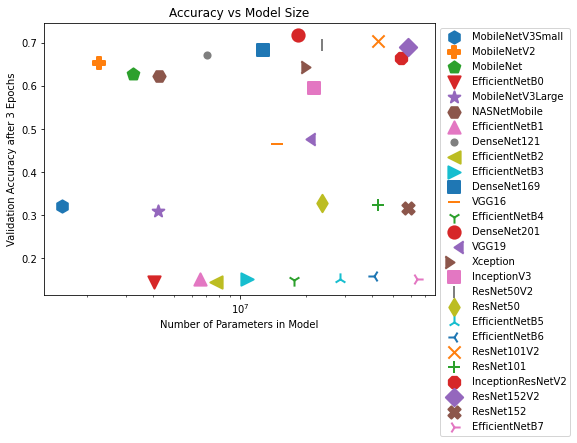

In [9]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');